# Evaluating Causal Models

In the previous chapter, we saw how to build what I called Conditional Average Treatment Effect (CATE) Models. The goal of those models is to leverage heterogeneity in the treatment effect in order to achieve personalisation. In simpler terms, we believe each unit has a different response to the treatment. For that reason, we want to give more of the treatment to those that respond better and less for those that respond worse. 

A model that can estimate the CATE is useful to segment our units into how responsive they are to a treatment. That's our end goal here. We saw that a CATE model was able to produce segments in a way that a purely predictive model couldn't do it. Namely, the CATE model managed to create partitions with different treatment elasticity \\(\frac{\delta y}{ \delta t}\\) while a prediction model was only able to partition the entities on the \\(Y\\) dimension. 

The CATE model we used was a simple linear regression. Of course we can do better than that. But first, we must get a very important topic out of the way. What is "better" in terms of a causal model? In other words, how can we evaluate and ultimately compare different causal models?

The natural thing to do is to check if the thing it is predicting, that is, \\(\frac{\delta y}{ \delta t}\\) is in accordance with the true elasticity. But you know we can't do that. Unlike with a predictive model, where we can observe the true value of \\(y\\), elasticity is not something we can see on an individual level. It is as if every entity had an underlying responsiveness, denoted by the slope of the line from treatment to outcome, but that we can't measure.

![img](./data/img/causal-model/elasticity.png)

This is a very very very hard thing to wrap our heads around and it took me about 3 years to get into something that is not a definitive answer, but it works. The trick is to use aggregate measurements of elasticity. Even if you can't estimate elasticity individually, you can do it for a group and that is what we will leverage here.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

Consider again our data from ice cream sales. Now, we have two sources of data. The first consists of non random data. In this source, price has been naturally defined, perhaps by the intuition of the ice cream seller. On the second source, `prices_rnd`, prices were randomly set, perhaps in some sort of experiment to understand how price affects sales.

We will use the non random data to estimate our causal models and the random data to evaluate it. As we will, see, random data is very valuable for this purpose, however, in real life, it is often expensive to collect random data (why would you set prices at random if you know some of them are not very good ones and will only make you lose money???). So, what tends to happen is that we often have an abundance of data where the treatment is **NOT** random and very few, if any, random data. I'm trying to replicate this situation here, but I'll also cover the case where you only have non random data.

And just in case you forgot, here is what the data looks like.

In [2]:
prices = pd.read_csv("./data/ice_cream_sales.csv")
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")
print(prices_rnd.shape)
prices.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


Now, let's train two models. The first one will be a linear regression with interactions terms so that elasticity is allowed to vary between units. 

$$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X}_i + \pmb{\beta_3 X}_i price_i + e_i
$$

Once we fit this model, we will be able to make elasticity prediction

$$
\widehat{\frac{\delta sales}{ \delta price}} = \hat{\beta_1} + \pmb{\hat{\beta_3} X}_i
$$



In [3]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

The second model will be fully nonparametric ML predictive model

$$
sales_i = G(X)_i + e_i
$$

In [4]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y]);

And just to make sure the model is not heavily overfitting, we can show the \\(R^2\\) on the data we've used to train it and on the new, unseen data. (For those more versed in Machine Learning, notice that some drop in performance is expected, because there is a concept drift. The model was trained in data where price is not random, but the test set has only randomized prices).

In [5]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447711


After training our models, we will get the elasticity from the regression model. Again, we will resort to a numerical approximation

$$
\frac{\delta y(t)}{\delta t} \approx  \frac{y(t+h) - y(t)}{h}
$$

To summarize, we will add the predictions from the ML model and the elasticity prediction from the linear model in a single dataframe, `prices_rnd_pred`. Moreover, let's also include a random model. The idea is that this model just outputs random numbers as predictions. It is obviously not very useful, but it shall serve well as a benchmark. Also, whenever we are talking about new ways of making evaluations, I always like to think about how a random (useless) model would do. If the random model is able to perform well on the evaluation criterion, that says something about how good the evaluation method really is. 

In [24]:
def predict_elast(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "m1_pred": m2.predict(prices_rnd[X]), ## predictive model
    "m2_pred": predict_elast(m1, prices_rnd), ## elasticity model
    "m3_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
    
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,m1_pred,m2_pred,m3_pred
0,25.8,1,0.3,7,230,224.067406,-13.096964,0.696469
1,22.7,3,0.5,4,190,189.889147,1.054695,0.286139
2,33.7,7,1.0,5,237,237.255157,-17.362642,0.226851
3,23.0,4,0.5,5,193,186.688619,0.564985,0.551315
4,24.4,1,1.0,3,252,250.342203,-13.717946,0.719469


## Elasticity by Model Band

Now that we have our predictions for elasticity, we need to evaluate how good they are. And remember, we can't observe elasticity, so there isn't a simple ground truth we can use. Instead, let's think back to what we want from our elasticity models. Perhaps that will give us some insights into how we should evaluate them. 

The idea of making treatment elasticity models came from the necessity of finding which units are more sensitive to the treatment and which are less. It came from a desire for personalisation. Maybe a marketing campaign is very effective in only one segment of the population. Maybe discounts only work for some type of customers. A good causal model should help us find which customers will respond better and worse to a proposed treatment. They should be able to separate units into how elastic or sensitive they are to the treatment. In our ice cream example, the model should be able to figure out in which days are people willing to spend more on ice cream or, in which days are their price elasticity less negative. 

If that is the goal, it would be very useful if we could somehow order units from more sensitive to less sensitive. Since we have the predicted elasticity, we can order the units by that prediction and hope it also orders them by the real elasticity. Sadly, we can't evaluate that ordering on a unit level. But, what if we don't need to? What if instead we evaluate groups defined by the ordering? We estimate elasticity for a sample is easy after all! Let's say that we partition our dataset into equal sized bands defined by our model. For each band we can compute the elasticity or the treatment effect. 

To understand this better, it's useful to picture the binary treatment case. Let's say prices can be either high or low. We can then plot sales on the Y axis, each of our models in the X axis and price as the color. Then, we split the data on the model axis into three equal sized groups. **If the treatment was randomly assigned**, we can easily estimate the ATE for each group \\(E[Y|T=1] - E[Y|T=0]
\\).

![img](./data/img/evaluate-causal-models/ate_bins.png)

In the image, we can see that the first model is somewhat good at predicting sales (high correlation with sales), but the groups produced by it have roughly the same treatment effect, as shown in the plot on the bottom. Two of the three segments have the same elasticity and only the last one has a different, lower elasticity.

On the other hand, each group produced by the second model has a different causal effect. Finally, the random model produces groups with the exact same elasticity. That's expected. If the model is indeed random, each segment it produces will be a random and representative sample of the data. So the elasticity in its groups should be roughly the same as the ATE on the entire dataset.

Just by looking at these plots, you can get a feeling of which model is better. The more ordered the elasticities look like and the more different from one another, the better. Here, model 2 is probably better than model 1, which is probably better than the random model.

Mathematically, we can estimate the elasticity using a single variable linear regression model. 

$$
y_i = \beta_0 + \beta_1t_i + e_i
$$

From the theory on simple linear regression, we know that

$$
\hat{\beta_1}=\dfrac{\sum (t_i - \bar{t}) (y_i - \bar{y})}{\sum(t_i - \bar{t})^2}
$$

where \\(\bar{t}\\) is the sample average for the treatment and \\(\bar{y}\\) is the sample average for the outcome. Here is what that looks like in code



In [25]:
@curry
def elast(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

We also need a function that segments the dataset into partitions of equal size and applies the elasticity to each partition. The following code should handle that.

In [26]:
def elast_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(elast(y=y, t=t))) # estimate the elasticity on each partition

What we can do now is plot the elasticity by band using the predictions we've made before. Here, we will use each model to construct partitions and then estimate the elasticity on each partition. 

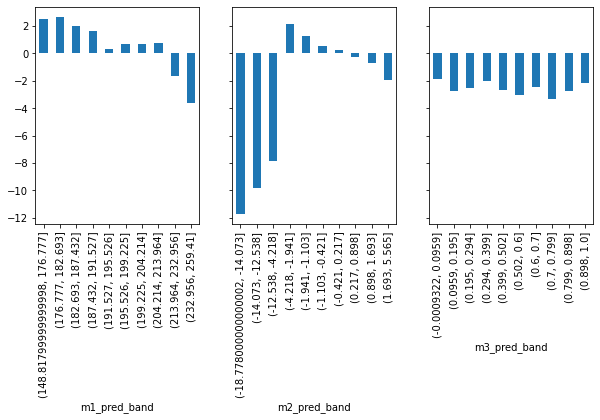

In [27]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in enumerate(axs):
    elast_by_band(prices_rnd_pred, f"m{m+1}_pred", "sales", "price").plot.bar(ax=ax)


First, look at the random model. It has roughly the same estimated elasticity in each of its partitions. We can already see just by looking at the plot that it won't help us much with personalisation since it can't distinguish between the high and low price elasticity days. Next, consider the predictive model, \\(m1\\). That model is actually promising! It manages to construct groups where the elasticity is high and others where the elasticity is low. That's exactly what we need. 

Finally, the causal model \\(m2\\) looks a bit weird. It identifies groups of really low elasticity. Those are days where people are very sensitive to price increases, so it's very useful for us to detect that so that we don't go on increasing prices on those types of days. The causal model also identifies some less sensitive regions, so it can successfully distinguish high from low elasticities. But the ordering is not as good as that of the predictive model. 

So, what should we decide? Which one is more useful? The predictive or the causal model? The predictive model has better ordering, but the causal model can better identify the extremes. The elasticity by band plot is a good first check, but it can't answer precisely which model is better. We need to move to something more elaborate.

## Cumulative Elasticity Curve

Consider again the illustrative example where price was converted to a binary treatment. We will take from where we left, so we had the elasticity of the treatment by band. What we can do now is order the band according to how sensitive they are. That is, we take the most sensitive group and place it in the first place, the second most sensitive group in the second place and so on. For both models 1 and 3, no re-ordering needs to be made, since they are already ordered. For model 2, we have to reverse the ordering. 

Once we have the ordered groups, we can construct what we will call the Cumulative Elasticity Curve. We first compute the elasticity of the first group; then, of the first and the second and so son, until we've included all the groups. In the end, we will just compute the elasticity for the entire dataset. Here is what it looks like for our example image.

![img](./data/img/evaluate-causal-models/cumm_elast.png)

Notice that the first bin in the cumulative elasticity is just the ATE from the most sensitive group according to that model. Also, for all the models, the cumulative elasticity will converge to the same point, which is the ATE for the entire dataset. 

Mathematically, we can define the cumulative elasticity as the elasticity estimated up until unit \\(k\\). 

$$
\widehat{y'(t)}_k = \hat{\beta_1}_k=\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2}
$$

To build the cumulative elasticity curve, run the above function iteratively in the dataset to produce the following sequence. 

$$
(\widehat{y'(t)}_1, \widehat{y'(t)}_2, \widehat{y'(t)}_3,..., \widehat{y'(t)}_N)
$$

This is a very useful sequence in terms of model evaluation because we can make preferences statements about it. First, a model is better to the degree that \\(widehat{y'(t)}_k > widehat{y'(t)}_{k+a}\\) for any \\(k\\) and \\(a>0\\). In words, if a model is good at ordering elasticity, the observed elasticity in the top \\(k\\) samples should be higher than the elasticity observed in top \\(k+a\\) samples. Or, simply put, if I look at the top units, they should have higher elasticity than units below them. 

Second, a model is better to the degree that \\(\widehat{y'(t)}_k - \widehat{y'(t)}_{k+a}\\) is the largest, for any \\(k\\) and \\(a>0\\). The intuition being that not only do we want the elasticity of the top \\(k\\) units to be higher than the elasticity of the units below them, but we want that difference to be as large as possible. 

To make it more concrete, here is this idea represented in code.

In [28]:
def cum_elast_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # cumulative computes the elasticity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([elast(ordered_df.head(rows), y, t) for rows in n_rows])

Some things to notice about this function. It assumes that the thing which ordered the elasticity is stored in the column passed to the `prediction` argument. Also, the first group has `min_periods` units, so it can be different from the others. The reason is that, due to small sample size, the elasticity can be too noisy at the beginning of the curve. To fix that, we can pass a first group which is already large enough. Finally, the `steps` argument defines how many extra units we include in each subsequent group.   

With this function, we can now plot the cumulative elasticity curve, according to the ordering produced by each of our models.

Cumulative Elasticity Curves have a normative role. They tell you how much of the population you should treat. Say you only have a good treatment response up until the top 30% of your units. This means you can only effectively treat those 30%. The higher the percentage you want to treat, the closer you get to the overall average treatment effect. If that effect is not good enough for you, then you'll have to settle with treating a lower percentage of the population. The cumulative elasticity curve makes that tradeoff explicit. For example, in our pricing example, if I want to increase prices only on days where the price sensitivity is half its average value of -2.5, I'll have to contend with increasing the price only on some days.

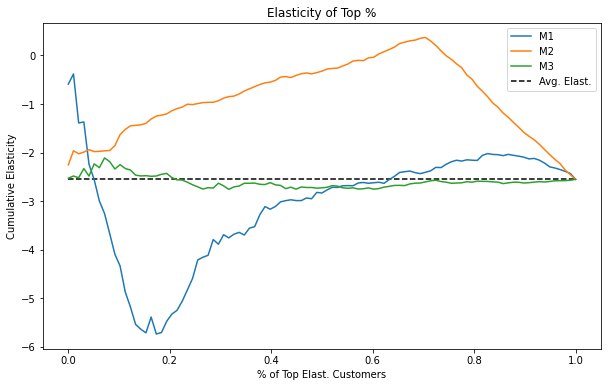

In [29]:
plt.figure(figsize=(10,6))

for m in range(3):
    cumm_elast = cum_elast_curve(prices_rnd_pred, f"m{m+1}_pred", "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumm_elast)))
    plt.plot(x/x.max(), cumm_elast, label=f"M{m+1}")

plt.hlines(elast(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cumulative Elasticity")
plt.title("Elasticity of Top %")
plt.legend();
        


Again, to better understand this, consider first the random model, \\(M3\\). It's cumulative elasticity is always oscillating around the average elasticity. This means that the model can't differentiate units by their elasticities. This makes the model not very good for policy making because it finds no tradeoff between treatment more and treatment effect. We'll get roughly the same elasticity if we treat 100% of units or only. 10%.

Next, look at the curve from the causal model \\(M2\\). That's an interesting curve, because it starts not very useful, with an elasticity close to the average. But it soon goes up to what looks like almost zero. It means we can increase prices on something like 70% of the days and still get a pretty low sensitivity to it. This is in accordance with what we saw previously on the elasticity by model bands. The causal model can identify the days where people are really sensitive to price increases. As it puts those in the last, we would manage to get a pretty decent elasticity while still treating the majority of the units.


In [30]:
def cummulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

This produces the following curves for our models. In the Qini, a theoretical random model goes from 0 to the average elasticity. Indeed, if we look at our random model (M0), it folows closely the theoretical random line. On the Qini curve, the biger the Area Under the Curve, the better the model at ordering the elasticity. So, consider again our elasticity model M1 and the predictive model M2. It is pretty clear that the elasticity model has a much bigger area under the curve than the predictive model. For this reason, it's offten easier to know which model is better by looking at the Qini curve.

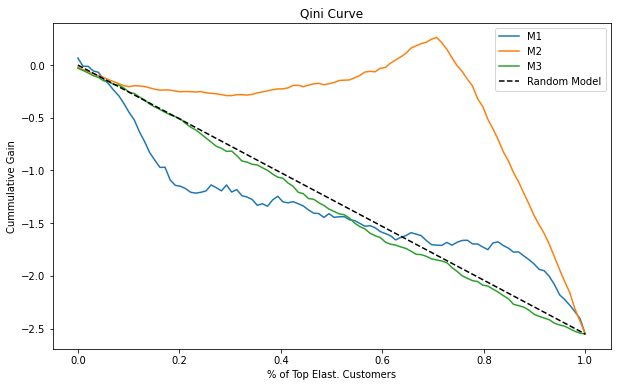

In [31]:
plt.figure(figsize=(10,6))

for m in range(3):
    cumm_gain = cummulative_gain(prices_rnd_pred, f"m{m+1}_pred", "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumm_gain)))
    plt.plot(x/x.max(), cumm_gain, label=f"M{m+1}")
    
plt.plot([0, 1], [0, elast(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cummulative Gain")
plt.title("Qini Curve")
plt.legend();

One downside of evaluation like the ones above is that they all deppend on having random data. That is because we need to trust our elasticity estimation, which is very complicated thing to do in the absense of random data. For all intend and purposes, I would only recomend those evaluations if you have some random data. However, this is not always possible. When it is not, there is still a way out, but I would still aproach it very critically. 

## Non Random Data

Cummulative elasticity and the Qini curves need to estimate the average elasticity of a sample in order to work properly. Remember that the average elasticity is the end point of the curves we've seen above. Is the average elasticity is off, the whole thing blows up. To give an example, let's say that, on our icecream example, because we used to rise prices during the weekends, it looked like the higher the price, the higher the sales ammount (wihch is obvious nonsense). When we plot such a Qini curve, it would look like the average price elasticity is positive and we would look for models that can segment the sample in a way to make it even more positive. Of course, this doesn't make any sence, since economic theory tells us that sales should go down as we increase price.

To correct that, we need to somehow debias our data. To show you how to do that, consider that we don't have access to the random data anymore. Now, we have to split our non random data into a training and a validation set.

In [32]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(prices, test_size=0.5)
train.shape, test.shape

((5000, 5), (5000, 5))

Next, we have to make it so that the evaluation or test set is not biased.

## Debiasing the Test

If we show the correlation on the test set, we can see that price is positively correlated with sales, meaning that sales should go up as we increase prices. This is obviously nonsense

In [33]:
test.corr()

,temp,weekday,cost,price,sales
temp,1.000000,-0.011791,0.004071,0.009437,0.376438
weekday,-0.011791,1.000000,0.012182,0.001593,0.006172
cost,0.004071,0.012182,1.000000,0.397086,-0.006410
price,0.009437,0.001593,0.397086,1.000000,0.082373
sales,0.376438,0.006172,-0.006410,0.082373,1.000000


If we plot our data, we can see why this is happening. Weekends (Saturday and Sunday) have higer price but also higher sales. We can see that this is the case because the weekend cloud of points seems to be to the right upper part of the plot. This idicates the same sort of bias we where talking about earlier.

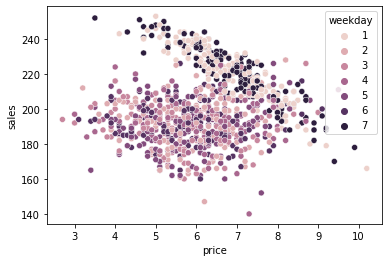

In [34]:
np.random.seed(123)
sns.scatterplot(data=test.sample(1000), x="price", y="sales", hue="weekday");

To debias this dataset we will need to models. The first model, let's call it \\(M_t(X)\\), predicts the treatment (price, in our case) using the confounder. Here, we will use a regression model for \\(M_t(X)\\).

In [35]:
m_t = smf.ols("price ~ cost + C(weekday) + temp", data=test).fit()
debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test)})

Once we have this model, we will construct the residuals

$$
\hat{t}_i = t_i - M_t(X_i)
$$

You can think of this residual as a version of the treatment that is unbiased or, better yet, that is inpossible to predict from the confounders \\(X\\). Since the confounders where already used to predict \\(t\\), the residual is by definition, unpredictable with \\(X\\). Another way of saying this is that the biase have been explained away by the model \\(M_t(X_i)\\), prudicing \\(\hat{t}_i\\) wich is as good as randomm

Of course this only works if we have in \\(X\\) all the confounders that causes both \\(T\\) and \\(Y\\). Just for the sake of ilustration, here is what happens to the data when we debiased \\(t\\). 

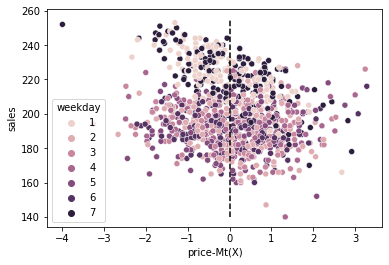

In [36]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales", hue="weekday")
plt.vlines(0, debiased_test["sales"].min(), debiased_test["sales"].max(), linestyles='--', color="black");

We can see that the weekends are no longer to the upper right corned. They got pushed to the center. As we can see, price (the treatment) doesn't differentiate in any sistematic way according to the weekday.

This alone is suficient to debias the dataset. But we can still do one other thing to make the debiased sample better. Namely, we can also contruct residuals for the outcome.


$$
\hat{y}_i = y_i - M_y(X_i)
$$

This doesn't make the set less biased, but it makes it easier to estimate the elasticity. Once again, you can think about \\(\hat{y}_i\\) as a version of \\(y_i\\) that is unpredictable from \\(X\\) or that had all its variances due to \\(X\\) explained away. If that is the case, the only thing left to explain \\(\hat{y}_i\\) is something we didn't used to construct it (not included in \\(X\\)), wich is only the treatment. 


In [37]:
m_y = smf.ols("sales ~ cost + C(weekday) + temp", data=test).fit()

debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test),
                               "sales-My(X)":test["sales"] - m_y.predict(test)})

Once we do such transformation, not only does weekday can't predict price, but now it can't also predict the residual of sales \\(\hat{y}\\). The only think left to predict this residual is the treatment. Also, notice something interesting. In the plot above, it was hard to know the direction of the price elasticity. It looked like as prices go up, sales go down, but there whas such a large variance in sales that it was hard to say that for sure. Now, when we plot the two residuals, it becomes much clear that sales indeed causes prices to go down.

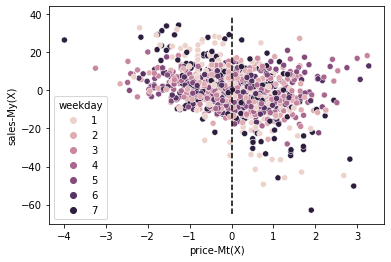

In [38]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales-My(X)", hue="weekday")
plt.vlines(0, debiased_test["sales-My(X)"].min(), debiased_test["sales-My(X)"].max(), linestyles='--', color="black");

To summarize, by predicting the treatment, we've constructed \\(\hat{t}\\) which works as an unbiased version of the treatment; by predicting the outcome, we've contructed \\(\hat{y}\\) wich is a version of the outcome that is only explained by the treatment

Now that we have a version of the test wich is debiased, we can proceede like we did before with our elasticity model. First, we fit it on the training set.

In [39]:
m3 = smf.ols(f"sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

Then, we make elasticity predictions on the debiased test set.

In [40]:
debiased_test_pred = debiased_test.assign(**{
    "m3_pred": predict_elast(m3, debiased_test),
})

debiased_test_pred.head()

,temp,weekday,cost,price,sales,price-Mt(X),sales-My(X),m3_pred
5770,28.9,6,1.0,6.9,210,0.866784,9.472567,-1.793514
9436,25.7,7,0.5,6.7,235,0.229630,10.497228,-13.191531
4098,22.6,3,0.5,5.6,171,0.154908,-18.420336,1.289809
7922,20.7,6,1.0,6.8,187,0.779103,1.319554,1.114852
1548,29.4,3,1.0,6.7,214,0.735878,12.684552,-1.805416


Now, when it comes to ploting the cummulative elasticity, we still order the dataset by the predictive elasticity, but now we use the debiased versions of the treatment and outcome to get the elasticity. This is equivalent to estimating \\(\beta_1\\) in the folowing regression model

$$
\hat{y}_i = \beta_0 + \beta_1 \hat{t}_i + e_i
$$

where the residuals have been made like we've described before.

In [41]:
plt.figure(figsize=(10,6))

cumm_elast = top_n_elast_curve(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_elast)))
plt.plot(x/x.max(), cumm_elast, label=f"M3")

plt.hlines(elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Elasticity of Top %")
plt.title("Cummulative Elasticity")
plt.legend();

NameError: name 'top_n_elast_curve' is not defined

<Figure size 720x432 with 0 Axes>

We can do the same thing for the Qini curve, of course.

In [ ]:
plt.figure(figsize=(10,6))

cumm_gain = cummulative_gain(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, label=f"M3", color="red")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cummulative Elasticity")
plt.title("Qini on Debiased Sample")
plt.legend();

And just to give you a sense of how inportant it is to debiase the set when computing the Qini curve, here is what it looks like if isetad use the biased sample. Notice that the price elasticity goes up, which is complete nonsense. As a result, a model that is good looks terrible.

In [ ]:
plt.figure(figsize=(10,6))

cumm_gain = cummulative_gain(debiased_test_pred, "m3_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, label=f"M3", color="red")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.title("Qini on Biased Sample")
plt.ylabel("Cummulative Elasticity")
plt.legend();

## Considering the Variance

Before we close, I just wanted to tuch on a brief topic wihch is variance. As well educated as we are in statistics, it feels wrong to not place a confidence interval around our Qini curve. Happly for us, since the Cummulative Elasticity curve is just the agregation of the coeficients of lots of linear regressions, we can place confidence interval around those estimates fairly easely. 

To achive such a thing, we will first create a function that returns the CI for use. I'm using the formula for the simple linear regression here

$$
s_{\hat\beta_1}=\sqrt{\frac{\sum_i\hat\epsilon_i^2}{(n-2)\sum_i(t_i-\bar t)^2}}
$$

but feel free to extract the CI however you want.

In [ ]:
def elast_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = elast(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

Now, we only need a minor modification on our `top_n_elast_curve` function. Instead of outputing the elasticity, we will now output the confidence interval for the elasticity.

In [ ]:
def top_n_elast_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    return np.array([elast_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

And finally, here is the cummulative elasticity curve with the 95% CI.

In [ ]:
plt.figure(figsize=(10,6))

cumm_gain = top_n_elast_curve_ci(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, color="red")

plt.hlines(elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cummulative Elasticity")
plt.title("Cummulative Elasticity")
plt.legend();

In [ ]:
def cummulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([elast_ci(ordered_df.head(rows).assign(**{t: lambda d: d[t] * (size/rows)}), y, t)
                     for rows in n_rows])

    return np.array([elast_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [ ]:
plt.figure(figsize=(10,6))

cumm_gain = cummulative_gain_ci(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, label=f"M3", color="red")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cummulative Elasticity")
plt.title("Qini on Debiased Sample")
plt.legend();

## Key Ideas